<a href="https://colab.research.google.com/github/minz1337/CS431/blob/main/GD3/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bước 1: Chuẩn bị dữ liệu

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

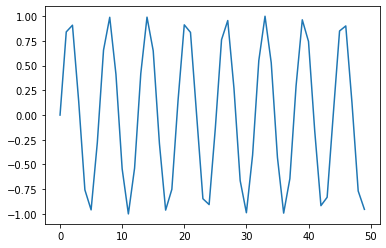

In [8]:
plt.plot(sin_wave[:50])

In [9]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [10]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [11]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

# Bước 2: Khởi tạo mô hình RNN


In [12]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [13]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Bước 3: Train Model


In [19]:
for epoch in range(nepoch):

    loss = 0.0
    

    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    
        prev_s = np.zeros((hidden_dim, 1))   
        for t in range(T):
            new_input = np.zeros(x.shape)    
            new_input[t] = x[t]             
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s


        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s

        dmulv = (mulv - y)

        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            if dU.max() > max_clip_value:
              dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
              

            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW

Epoch:  1 , Loss:  [[120039.23190142]] , Val Loss:  [[60017.68638778]]
Epoch:  2 , Loss:  [[78.25715575]] , Val Loss:  [[39.12171453]]
Epoch:  3 , Loss:  [[46.23906399]] , Val Loss:  [[23.10087382]]
Epoch:  4 , Loss:  [[143.66616562]] , Val Loss:  [[71.71144111]]
Epoch:  5 , Loss:  [[64.56875688]] , Val Loss:  [[32.21997915]]
Epoch:  6 , Loss:  [[451.91663038]] , Val Loss:  [[225.95729962]]
Epoch:  7 , Loss:  [[72.52127826]] , Val Loss:  [[36.25119647]]
Epoch:  8 , Loss:  [[435.51410825]] , Val Loss:  [[217.77009207]]
Epoch:  9 , Loss:  [[75.49798775]] , Val Loss:  [[37.75164841]]
Epoch:  10 , Loss:  [[165.94558578]] , Val Loss:  [[82.98012595]]
Epoch:  11 , Loss:  [[77.80303434]] , Val Loss:  [[38.89249155]]
Epoch:  12 , Loss:  [[171.21958282]] , Val Loss:  [[85.61244172]]
Epoch:  13 , Loss:  [[40.8842826]] , Val Loss:  [[20.42479467]]
Epoch:  14 , Loss:  [[220.94783848]] , Val Loss:  [[110.47924819]]
Epoch:  15 , Loss:  [[306.01301561]] , Val Loss:  [[153.0300604]]
Epoch:  16 , Loss:

# Bước 4: Predict Model

In [21]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
preds = np.array(preds)

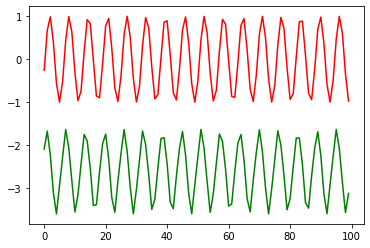

In [22]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()